### Importing Data
Movie data was obtained from Kaggle's TMDB dataset (https://www.kaggle.com/tmdb/tmdb-movie-metadata). The data was cleaned with the `cleaned_data.py` script. The `import_clean_csv` method from the `import_data.py` module is used to import the cleaned TMDB data

In [102]:
import os
import importlib.util
import pandas as pd
import numpy as np
import sys
from scipy import stats
from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm_pandas
import seaborn as sns
tqdm().pandas()

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [103]:
%load_ext autoreload
%autoreload 2

current_file_path = os.path.abspath(os.path.join("__file__" ,"../.."))
tools_path = os.path.abspath(os.path.join(current_file_path, 'src', 'tools'))
sys.path.append(os.path.abspath(os.path.join(tools_path)))
import thinkstats2, thinkplot
from data_vis import get_plotly
import eda_tools as eda

import_data_path = os.path.join(current_file_path,'src','data')

spec = importlib.util.spec_from_file_location("import_clean_csv", os.path.join(import_data_path,"import_clean_data.py"))
import_data = importlib.util.module_from_spec(spec)
spec.loader.exec_module(import_data)

data = import_data.import_clean_csv()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Importing Packages for Visualizations

In [104]:
#Following Python packages are necessary for data visualiations below

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import cufflinks as cf

init_notebook_mode(connected=True)
cf.go_offline()

In [105]:
# create dataframes from cleaned data
movies = data['tmdb_movie_main'].set_index(['movie_id', 'title'])
movies['release_date'] = pd.to_datetime(movies['release_date'])
cast = data['tmdb_cast_credit']

In [106]:
first_billing = cast.groupby(['movie_id', 'title'], as_index=False)['name'].first()
first_billing.set_index(['movie_id', 'title'], inplace=True)

In [107]:
movies['net'] = movies.revenue - movies.budget
movies['net_pct'] = movies.revenue.divide(movies.budget) - 1

key_metrics = ['budget', 'revenue','net', 'net_pct','runtime', 'vote_average', 'vote_count','popularity', 'release_date']
Total = movies[key_metrics]
Hits = Total[Total.net >= 0]
Flops = Total[Total.net < 0]

Total.name = "Total"
Hits.name = "Hits"
Flops.name = "Fops"

# Actors
The actors attached to a film garner the most attention from the general public. A movie starring a well known celebrity such as Tom Cruise is sure to generate more buzz than someone who is relatively new and unknown. It is also harder to predict the performance of a film if the lead is cast to an actor with no history of hits to his/her credit. In the boxplot below, we can see that Tom Cruise may be the most consistently profitable actor.

In [108]:
cast[cast.movie_id == 9396]
first_billing.head()

name
movie_id title                         
5        Four Rooms            Tim Roth
11       Star Wars          Mark Hamill
12       Finding Nemo     Albert Brooks
13       Forrest Gump         Tom Hanks
14       American Beauty   Kevin Spacey

In [109]:
movies_with_actors = movies.merge(first_billing, left_index=True, right_index=True)
actors_df = movies_with_actors.reset_index()

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

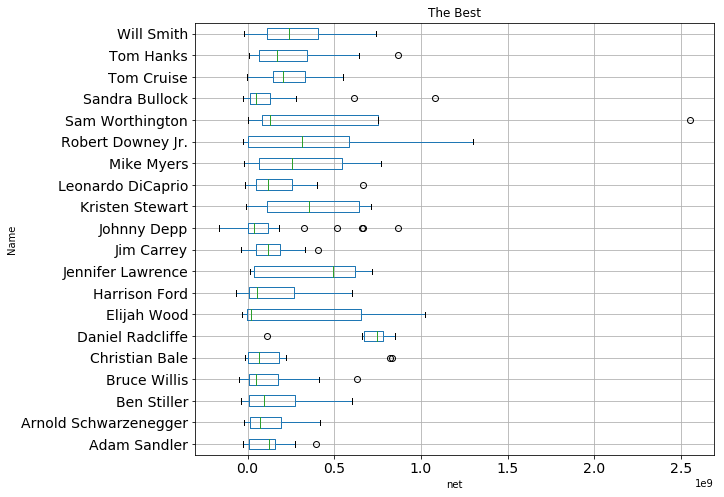

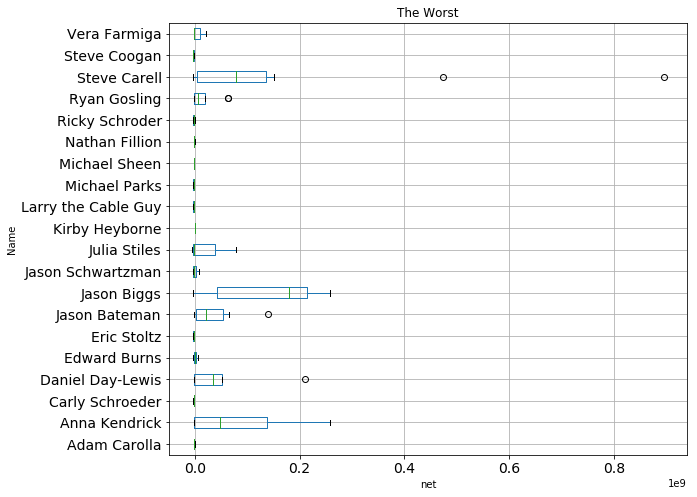

In [110]:
sum_top_working_actors, sum_worst_working_actors = eda.get_best_worst_personnel(actors_df, ('net', 'sum'))

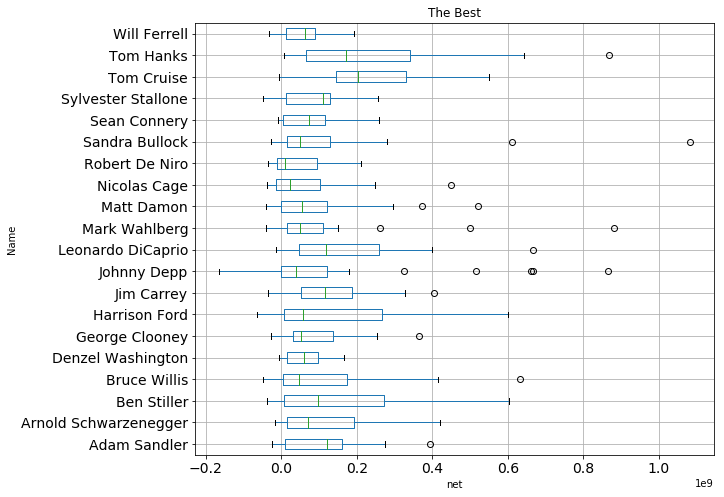

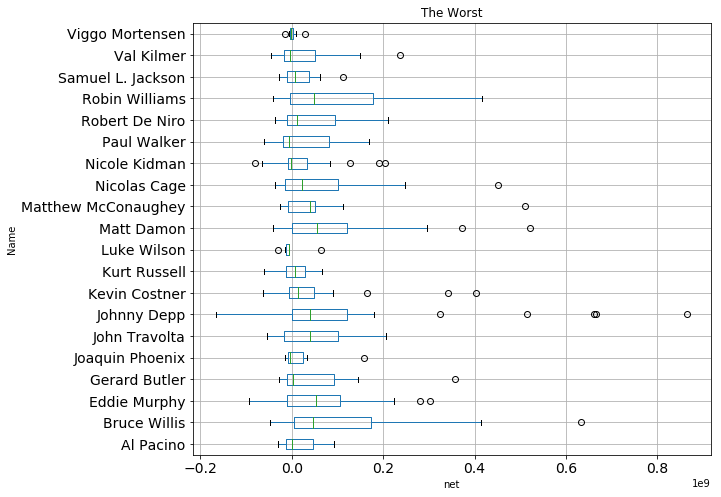

In [111]:
top_working_actors, worst_working_actors = eda.get_best_worst_personnel(actors_df, ('net', 'count'))

It is also surprising to see that some of the names associated with most amount of profitable movies also appear in the list of actors with the most amount of film flops (e.g., Samuel L Jackson and Robert DeNiro). For these actors, over the span of their entire career, they tend to bring a net positive. 

It will be interesting to investigate the profitability actors over time. Nicolas Cage, for example, had a string of major hits in the late 1990s (e.g. The Rock, Con-Air), and because less consistent as time went on -- as well as participating in some major flops. He was attached to a huge hit in The Croods, but it was an animated film and it's difficult to attribute the movie's success to Nicolas Cage's involvement.

In [112]:
data = []
for actor in top_working_actors:
    actor_history = actors_df[actors_df['name'] == actor].sort_values(by='release_date')
    trace = go.Scatter(x=actor_history['release_date'],y=actor_history['net'],text=actor_history['title'], name=actor)
    data.append(trace)

layout=go.Layout(title="Time History of Top Grossing Actors")
fig = go.Figure(data=data,layout=layout)
iplot(fig)

In [113]:
data = []
for actor in sum_worst_working_actors:
    actor_history = actors_df[actors_df['name'] == actor].sort_values(by='release_date')
    trace = go.Scatter(x=actor_history['release_date'],y=actor_history['net'],text=actor_history['title'], name=actor)
    data.append(trace)

layout=go.Layout(title="Time History of Lowest Grossing Actors")
fig = go.Figure(data=data,layout=layout)
iplot(fig)

HBox(children=(IntProgress(value=0, max=1811), HTML(value='')))

Exception in thread Thread-17:
Traceback (most recent call last):
  File "c:\users\ill will\appdata\local\programs\python\python36-32\Lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "c:\users\illwil~1\virtua~1\capsto~1\lib\site-packages\tqdm\_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "c:\users\illwil~1\virtua~1\capsto~1\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



HBox(children=(IntProgress(value=0, max=4330), HTML(value='')))


[ 1811.   653.   396.  1470.]


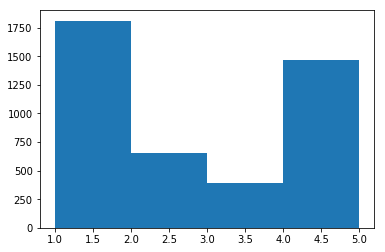

In [114]:
binned_actors_df = eda.bin_by_credits(actors_df, 'name', [1,2,3,4,5])

In [115]:
binned_actors_df['release_day'] = binned_actors_df.release_date.dt.day
binned_actors_df['release_month'] = binned_actors_df.release_date.dt.month
binned_actors_df['release_year'] = binned_actors_df.release_date.dt.year

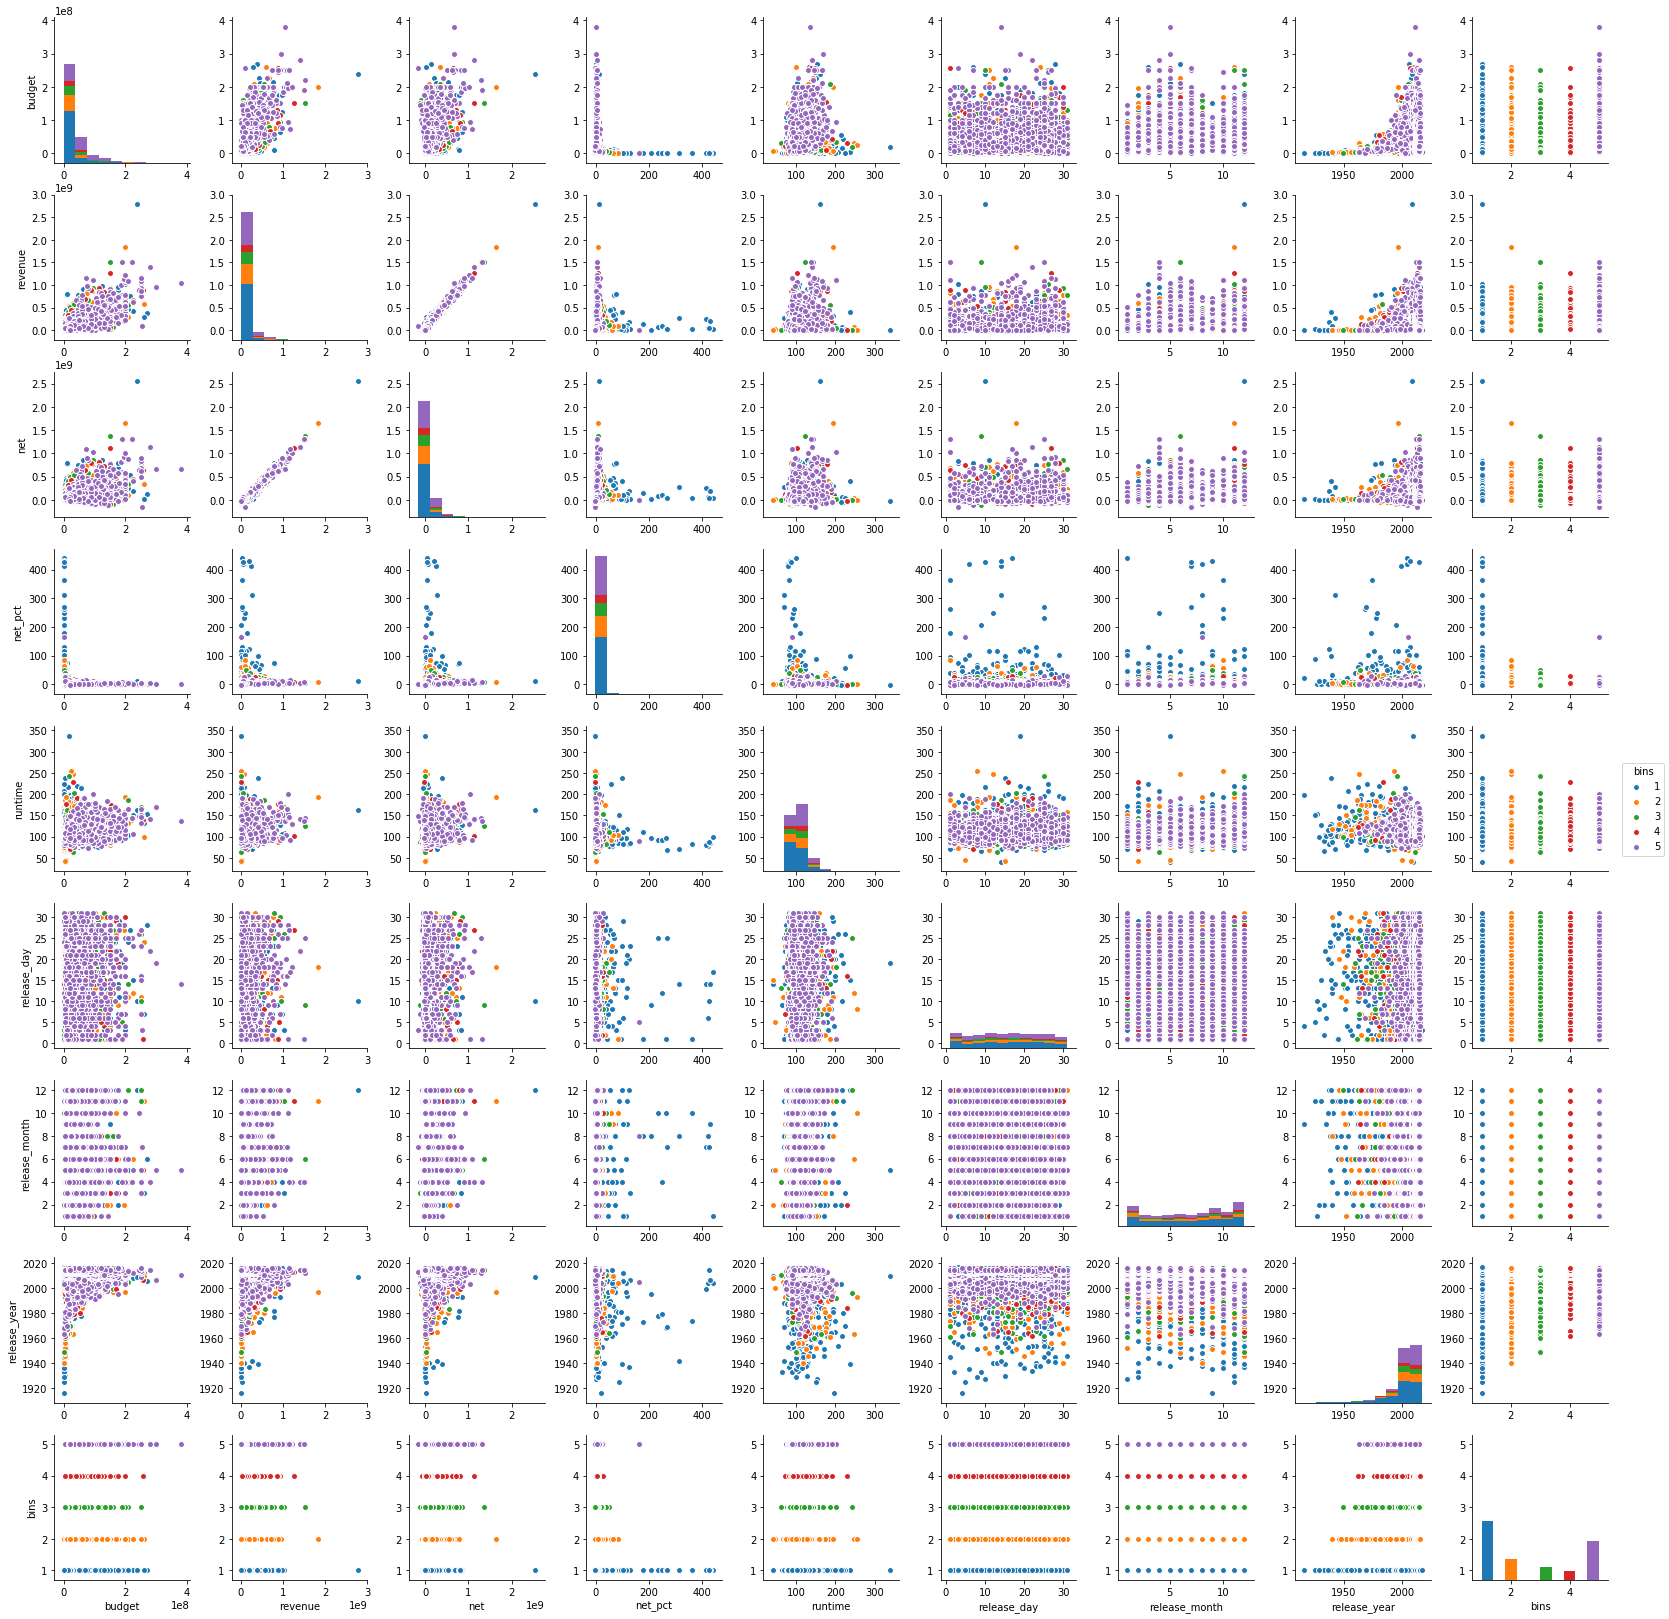

In [116]:
sns.pairplot(binned_actors_df[[
    'budget', 'revenue','net', 'net_pct','runtime',
    'release_day','release_month', 'release_year','bins'
    ]], hue='bins')